# Set Up

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [54]:
import numpy as nnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import NMF

from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing import text, sequence
from keras.callbacks import LearningRateScheduler

In [52]:
Input(shape=(784,))

<tf.Tensor 'input_1:0' shape=(?, 784) dtype=float32>

In [53]:
from gensim.models import word2vec

In [3]:
plt.rcParams['font.size'] = 18

# Column Explanation

# Preprocessing

In [4]:
class Preprocessing(object):
    
    def __init__(self, kind, nrows=10000, drop=False):
        self.df = pd.read_csv(f'../data/{kind}.csv', nrows=nrows)
        if drop: self._drop_columns()
        self._to_timestamp()
        self._rating()
        self._label_encode()
        
    def _drop_columns(self):
        cols = ['male', 'female', 'other_gender', 'transgender',
                'white', 'black', 'asian', 'jewish', 'latino', 'other_race_or_ethnicity',
                'atheist', 'buddhist', 'christian', 'hindu', 'muslim', 'other_religion',
                'bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation',
                'intellectual_or_learning_disability', 'other_disability', 'physical_disability', 'psychiatric_or_mental_illness']
        self.df = self.df.drop(columns=cols)
        
    def _to_timestamp(self):
        self.df['created_date'] = pd.to_datetime(self.df['created_date'])
        self.df['time_stamp'] = self.df['created_date'].apply(lambda x: x.timestamp())
        
    def _rating(self):
        self.df['rating'] = self.df['rating'].apply(lambda x: 1 if x=='approved' else 0)
        
    def _label_encode(self):
        self.df['publication_id'] = LabelEncoder().fit_transform(self.df['publication_id'])
        self.df['parent_id'] = LabelEncoder().fit_transform(self.df['parent_id'].fillna(0))
        self.df['article_id'] = LabelEncoder().fit_transform(self.df['article_id'])

In [5]:
Preprocessing('train', nrows=1000).df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,time_stamp
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,0,0,0,0,0,0.0,0,4,1.443524e+09
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,0,0,0,0,0,0.0,0,4,1.443524e+09
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,0,0,0,0,0,0.0,0,4,1.443524e+09
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,0,0,0,0,0,0,0.0,0,4,1.443524e+09
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,0,0,0,0,1,0,0.0,4,47,1.443524e+09


# Making Feature

In [6]:
class Feature(Preprocessing):
    
    def __init__(self, kind, nrows=1000):
        super().__init__(kind, nrows=nrows)
        self._text_length()
        self._capital_number()
        self._capital_rate()
        self._exclamation_number()
        self._question_number()
        self._punctuation_number()
        self._symbol_number()
        self._word_number()
        self._unique_word_number()
        self._unique_word_rate()
        self._smile_number()
        
    def _text_length(self):
        self.df['text_len'] = self.df['comment_text'].apply(len)
        
    def _capital_number(self):
        self.df['capital_num'] = self.df['comment_text'].apply(lambda x: sum(1 for c in x if c.isupper()))
        
    def _capital_rate(self):
        self.df['capital_rate'] = self.df['capital_num']/self.df['text_len']
        
    def _exclamation_number(self):
        self.df['exclamation_num'] = self.df['comment_text'].apply(lambda x: x.count('!'))
        
    def _question_number(self):
        self.df['question_num'] = self.df['comment_text'].apply(lambda x: x.count('?'))
        
    def _punctuation_number(self):
        self.df['punctuation_num'] = self.df['comment_text'].apply(lambda x: sum(x.count(w) for w in ',.;:'))
        
    def _symbol_number(self):
        self.df['symbol_num'] = self.df['comment_text'].apply(lambda x: sum(x.count(w) for w in '*$%&'))
        
    def _word_number(self):
        self.df['word_num'] = self.df['comment_text'].apply(lambda x: len(x.split()))
        
    def _unique_word_number(self):
        self.df['uni_word_num'] = self.df['comment_text'].apply(lambda x: len(set(w for w in x.split())))
        
    def _unique_word_rate(self):
        self.df['uni_word_rate'] = self.df['uni_word_num']/self.df['word_num']
        
    def _smile_number(self):
        self.df['smile_num'] = self.df['comment_text'].apply(lambda x: sum(x.count(w) for w in (':-)', ':)', ';-)', ';)')))

In [8]:
Feature('train').df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,capital_num,capital_rate,exclamation_num,question_num,punctuation_num,symbol_num,word_num,uni_word_num,uni_word_rate,smile_num
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,3,0.029703,1,2,3,0,19,19,1.000000,0
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,3,0.026316,3,0,2,0,22,22,1.000000,0
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2,0.023256,1,0,2,0,16,16,1.000000,0
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,3,0.035714,0,2,0,0,17,16,0.941176,0
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,0,0.000000,0,0,1,0,8,8,1.000000,0


# Modeling

## LSTM

In [ ]:
embedding_files = ['../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec',
                   '../input/glove840b300dtxt/glove.840B.300d.txt']
model_num = 2
batch_size = 512
lstm_unit = 128
dence_hiden_unit = 4*lstm_unit
epoch = 4
max_len = 220

In [1]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)


def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            pass
    return embedding_matrix
    

def build_model(embedding_matrix, num_aux_targets):
    words = Input(shape=(max_len))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(CuDNNLSTM(lstm_unit, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(lstm_unit, return_sequences=True))(x)

    hidden = concatenate([GlobalMaxPooling1D()(x), GlobalAveragePooling1D()(x)])
    hidden = add([hidden, Dense(dence_hiden_unit, activation='relu')(hidden)])
    hidden = add([hidden, Dense(dence_hiden_unit, activation='relu')(hidden)])
    result = Dense(1, activation='sigmoid')(hidden)
    aux_result = Dense(num_aux_targets, activation='sigmoid')(hidden)
    
    model = Model(inputs=words, outputs=[result, aux_result])
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model
    

def preprocess(data):
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`"+'""“”’'+'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text
    
    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

In [2]:
def main():
    train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
    test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

    x_train = preprocess(train['comment_text'])
    y_train = np.where(train['target'] >= 0.5, 1, 0)
    y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
    x_test = preprocess(test['comment_text'])

    tokenizer = text.Tokenizer()
    tokenizer.fit_on_texts(list(x_train)+list(x_test))

    x_train = tokenizer.texts_to_sequences(x_train)
    x_test = tokenizer.texts_to_sequences(x_test)
    x_train = sequence.pad_sequences(x_train, maxlen=max_len)
    x_test = sequence.pad_sequences(x_test, maxlen=max_len)

    embedding_matrix = np.concatenate([build_matrix(tokenizer.word_index, f) for f in embeding_files], axis=-1)
    
    checkpoint_predictions = []
    weights = []

    for model_idx in range(model_num):
        model = build_model(embedding_matrix, y_aux_train.shape[-1])
        for global_epoch in range(epoch):
            model.fit(x_train, [y_train, y_aux_train],
                      batch_size=batch_size,
                      epochs=1,
                      verbose=2,
                      callbacks=[LearningRateScheduler(lambda x: 1e-3*(0.6**global_epoch))])
            checkpoint_predictions.append(model.predict(x_test, batch_size=2048)[0].flatten())
            weights.append(2**global_epoch)

    predictions = np.average(checkpoint_predictions, weights=weights, axis=0)

    submission = pd.DataFrame.from_dict({'id': test['id'], 'prediction': predictions})
    submission.to_csv('submission.csv', index=False)

# Data Explanation

In [45]:
class Figure(Preprocessing):
    
    def __init__(self, nrows=10000, preprocessing=True, drop=False):
        if preprocessing:
            super().__init__('train', nrows=nrows, drop=drop)
        
    def date_target(self):
        x = self.df['time_stamp']
        y = self.df['target']
        plt.figure(figsize=(10, 7))
        plt.scatter(x, y, s=2)
        plt.xlabel('Time Stamp')
        plt.ylabel('Toxic Rate')
        plt.tight_layout()
        plt.show()
        
    def date_histogram(self):
        x = self.df['created_date']
        plt.figure(figsize=(10, 7))
        plt.hist(x, bins=100)
        plt.xlabel('Created Date')
        plt.ylabel('Count Number')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    def rating_histogram(self):
        x = self.df['rating']
        plt.figure(figsize=(10, 7))
        plt.hist(x, bins=2, rwidth=0.9)
        plt.xlabel('Rating')
        plt.ylabel('Count Number')
        plt.xticks([0.25, 0.75], ['rejected', 'approved'])
        plt.tight_layout()
        plt.show()
        
    def rating_boxplot(self):
        plt.figure(figsize=(10, 7))
        sns.boxplot(x='rating', y='target', data=self.df)
        plt.xlabel('Rating')
        plt.ylabel('Toxic Rate')
        plt.xticks([0, 1], ['rejected', 'approved'])
        plt.tight_layout()
        plt.show()
        
    def publication_histogram(self):
        x = self.df['publication_id']
        xticks = x.unique()
        print(xticks)
        bins = x.nunique()
        plt.figure(figsize=(10, 7))
        plt.hist(x, bins=bins, rwidth=0.9)
        plt.xlabel('Publication ID')
        plt.ylabel('Count Number')
        plt.xticks(xticks)
        plt.tight_layout()
        plt.show()
        
    def parent_histogram(self):
        x = self.df['parent_id'].dropna()
        bins = x.nunique()
        plt.figure(figsize=(10, 7))
        plt.hist(x, bins=bins, rwidth=0.9)
        plt.xlabel('Parent ID')
        plt.ylabel('Count Number')
        plt.ylim(0, 6)
        plt.tight_layout()
        plt.show()
        
    def correlation_heatmap(self, nrows=10000):
        df = Feature('train', nrows=nrows).df
        features = ['text_len',
                    'capital_num', 'capital_rate',
                    'exclamation_num', 'question_num', 'punctuation_num', 'symbol_num',
                    'word_num', 'uni_word_num', 'uni_word_rate',
                    'smile_num']
        columns = ['target',
                   'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat',
                   'funny', 'wow', 'sad', 'likes', 'disagree',
                   'sexual_explicit',
                   'identity_annotator_count', 'toxicity_annotator_count']
        rows = [{c: df[f].corr(df[c]) for c in columns} for f in features]
        df_corr = pd.DataFrame(rows, index=features)
        plt.figure(figsize=(10, 7))
        sns.heatmap(df_corr, center=0.0)
        
    def demographic_weight(self):
        columns = ['target',
                   'male', 'female', 'other_gender', 'transgender',
                   'white', 'black', 'asian', 'jewish', 'latino', 'other_race_or_ethnicity',
                   'atheist', 'buddhist', 'christian', 'hindu', 'muslim', 'other_religion',
                   'bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation',
                   'intellectual_or_learning_disability', 'other_disability', 'physical_disability', 'psychiatric_or_mental_illness']
        df = self.df.loc[:, columns].dropna()
        weight = df.iloc[:, 1:].multiply(df.iloc[:, 0], axis='index').sum()/df.iloc[:, 1:][df.iloc[:, 1:]>0].count()
        weight = weight.sort_values(ascending=False)
        plt.figure(figsize=(10, 7))
        sns.barplot(x=weight.values, y=weight.index, alpha=0.8)
        plt.xlabel('Weighted Toxic')
        plt.ylabel('Demographics')
        plt.show()
        
    def wordcloud(self):
        text = self.df['comment_text'].values
        wc = WordCloud(width=480, height=320)
        wc.generate(str(text))
        plt.figure(figsize=(15, 12))
        plt.imshow(wc)
        plt.axis('off')
        plt.show()

## Created Date

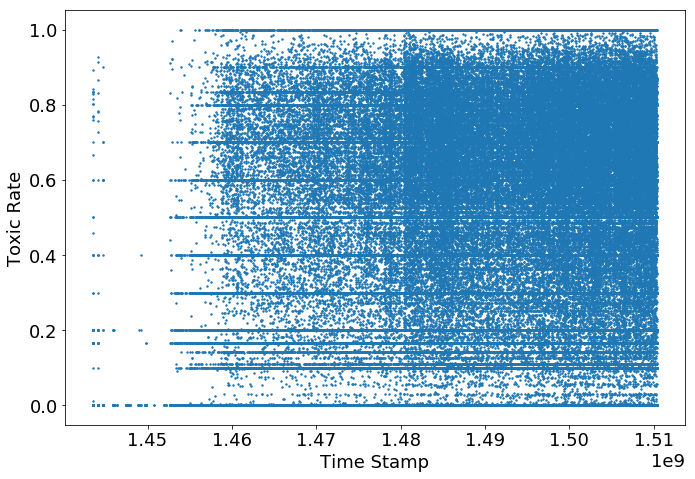

In [149]:
Figure(nrows=None, drop=True).date_target()

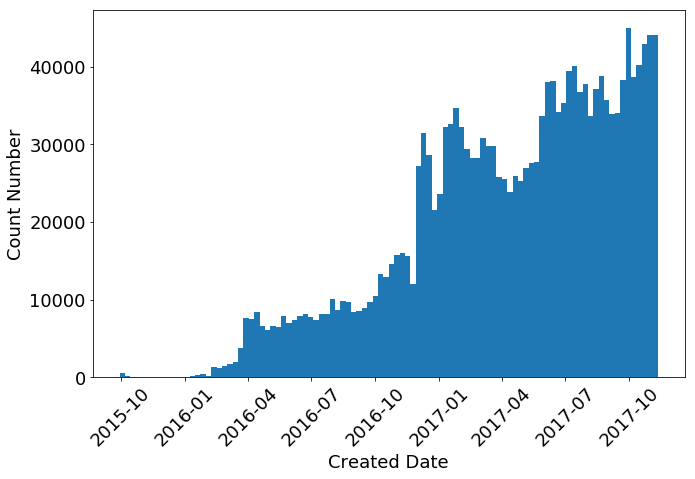

In [152]:
Figure(nrows=None, drop=True).date_histogram()

## Rating

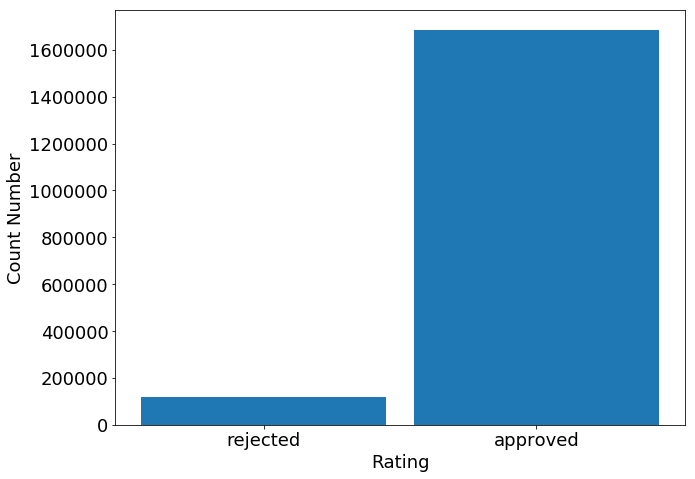

In [183]:
Figure(nrows=None, drop=True).rating_histogram()

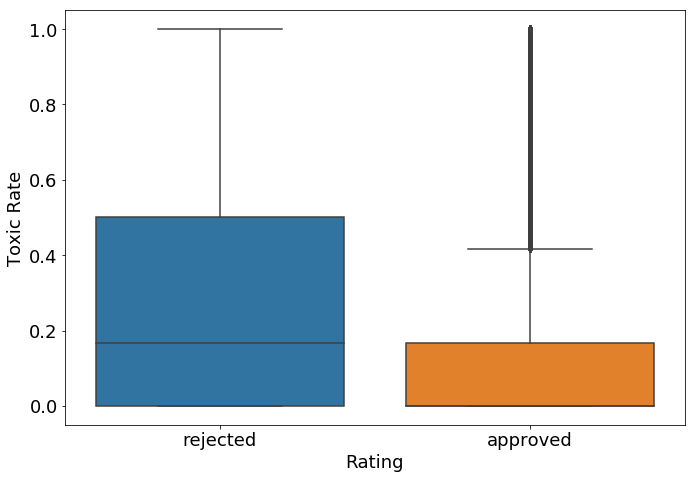

In [184]:
Figure(nrows=None, drop=True).rating_boxplot()

[  2   6 111]


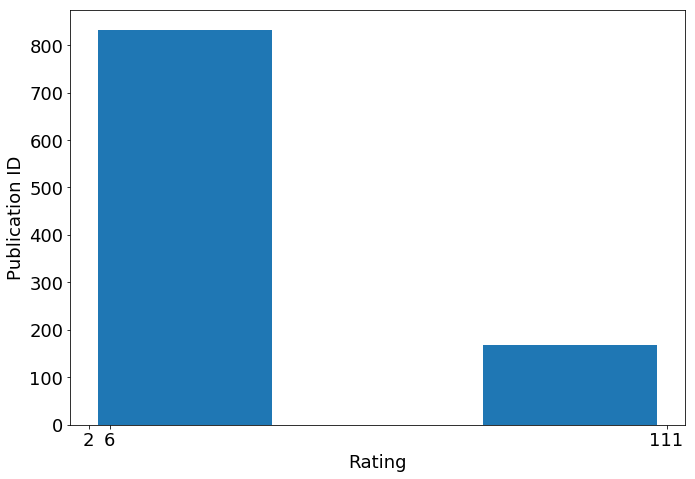

In [193]:
Figure(nrows=1000, drop=True).publication_histogram()

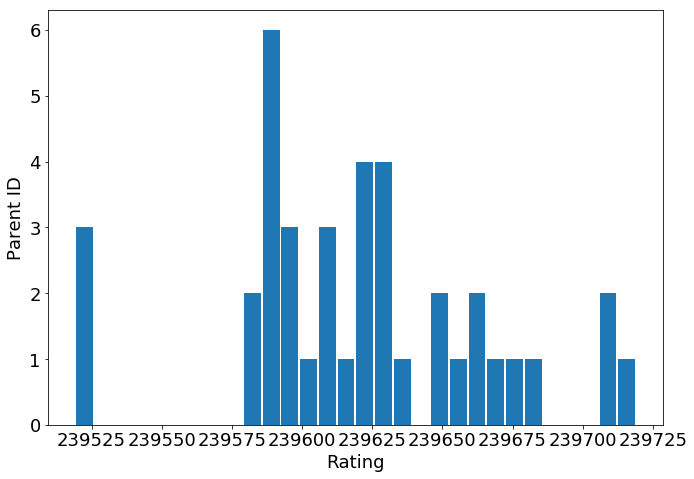

In [205]:
Figure(nrows=100, drop=True).parent_histogram()

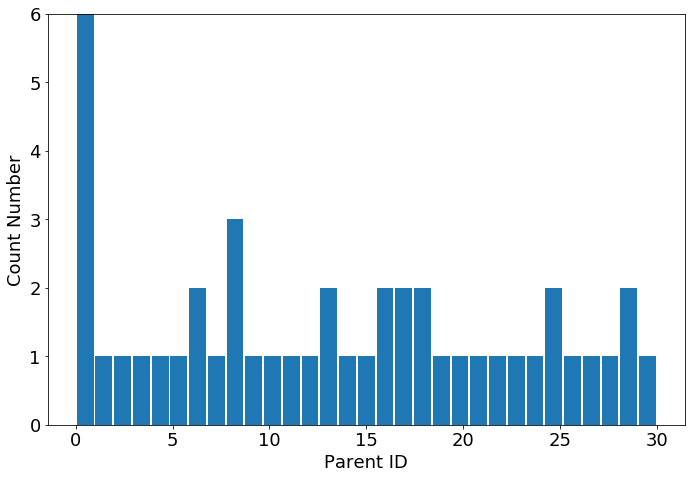

In [244]:
Figure(nrows=100, drop=True).parent_histogram()

## Feature Correlation

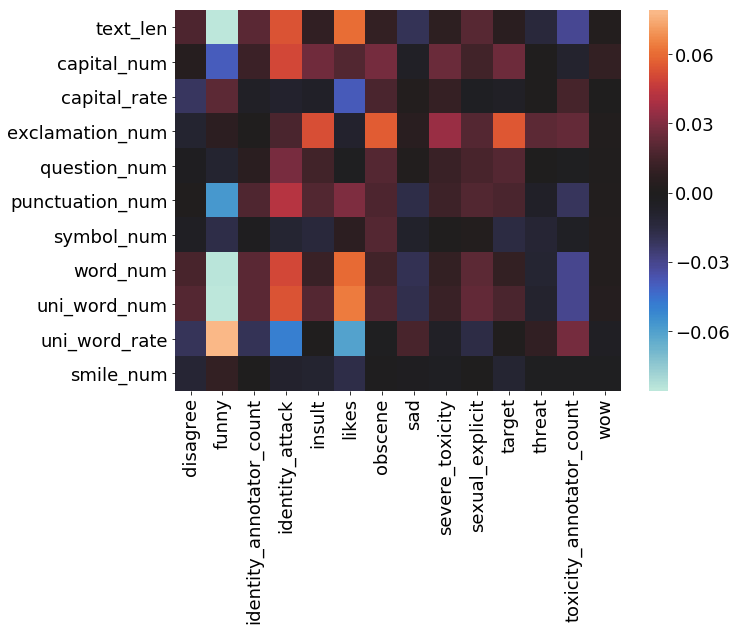

In [33]:
Figure(preprocessing=False).correlation_heatmap(nrows=None)

## Demographic Weight

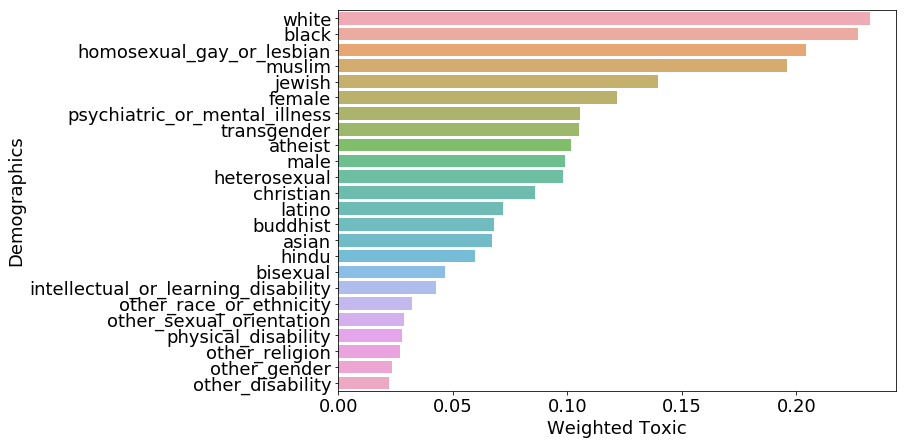

In [11]:
Figure(nrows=None).demographic_weight()

## WordCloud

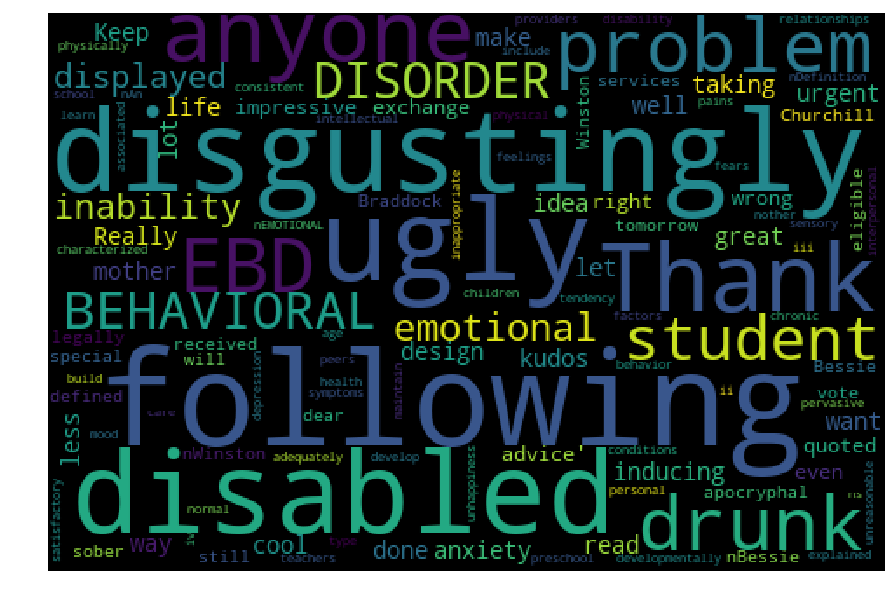

In [47]:
Figure(nrows=None, drop=True).wordcloud()